In [1]:
import os
import sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

import quandl
import numpy as np
import pandas as pd
import datetime as dt
from time import sleep

from src.util.download_sp500 import *

import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = (10.0, 8.0)
%matplotlib inline
%load_ext autoreload
%autoreload 2

In [2]:
np.random.seed(100)
quandl.ApiConfig.api_key = "" # Need to get api key from Quandl.
# References:
# http://ledoit.net/honey.pdf
# https://www.quantopian.com/lectures/estimating-covariance-matrices

In [3]:
start = dt.datetime.strptime("2016-11-05", "%Y-%M-%d")
end = dt.datetime.strptime("2017-11-05", "%Y-%M-%d")
# Set update to true if you want to work with new data with different time ranges. Note that you will likely have to
# amend the length of the periods. Warning: This will take some time to get the data.
update = False

In [4]:
if update:
    sp500 = download_sp500(start, end)
    sp500.to_pickle("../data/sp500_adj_close.pickle")
else:
    sp500 = pd.read_pickle("../data/sp500_adj_close.pickle")


In [5]:
# Get % of NaN per ticker
nans = sp500.head().isnull().sum()/len(sp500)
nans = nans[nans > 0]
nans.sort_values(inplace=True)
nans

FTV     0.019685
SPGI    0.019685
UA      0.019685
dtype: float64

In [6]:
sp500.fillna(method="ffill")
nans = sp500.head().isnull().sum()/len(sp500)
nans = nans[nans > 0]
nans.sort_values(inplace=True)
nans
sp500['UA'].head(10)
# FTV, SPGI, UA are missing blocks of values, lets remove columns completely. Acceptable for demonstration purposes.
del sp500['UA']
del sp500['SPGI']
del sp500['FTV']

In [7]:
# We can confirm that the data frame contains no NaNs now.
nans = sp500.head().isnull().sum()/len(sp500)
nans = nans[nans > 0]
nans.sort_values(inplace=True)
nans

Series([], dtype: float64)

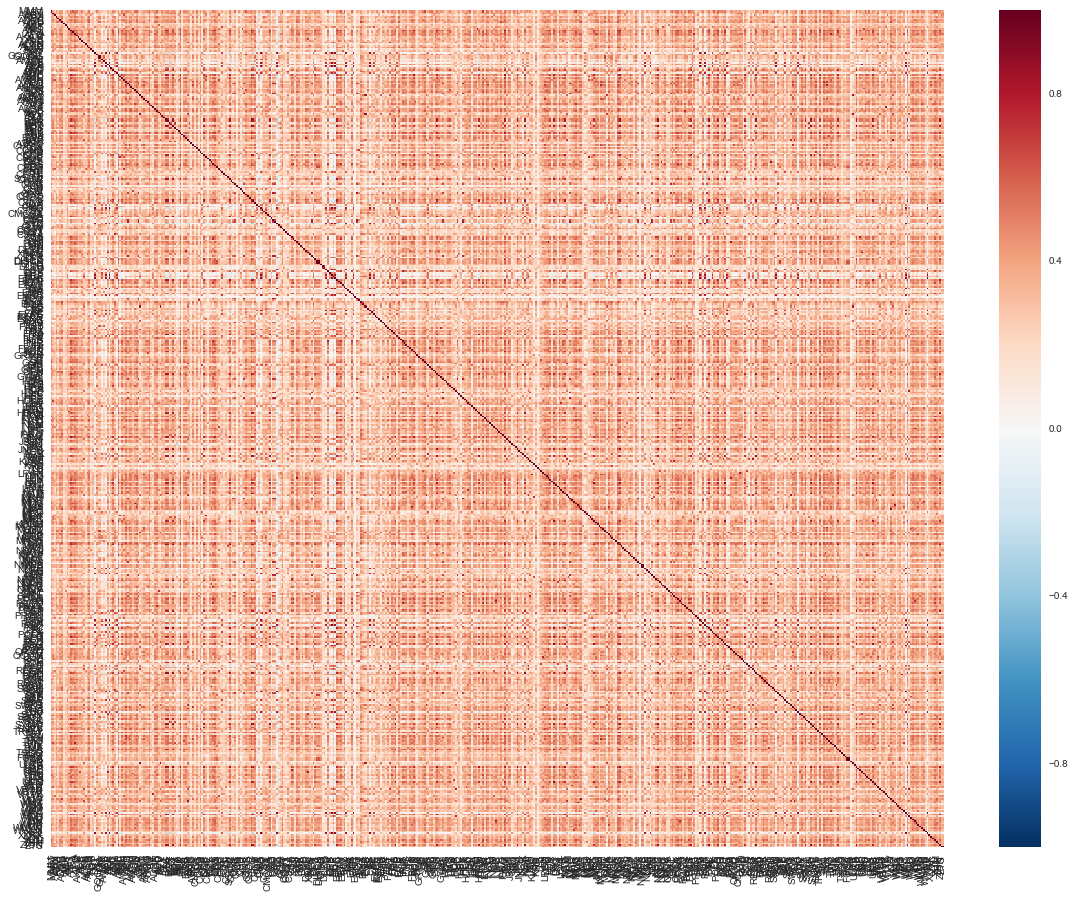

In [8]:
import seaborn as sns
ret = sp500.pct_change()[1:]
plt.subplots(figsize=(20,15))
# There are specs of pairs that are negatively correlated, while we can visually see that majority have some magnitude
# of positive pairwise correlation.
sns.heatmap(ret.corr())

In [9]:
ret.corr().head()

,MMM,ABT,ABBV,ACN,ATVI,AYI,ADBE,AMD,AAP,AES,...,WYNN,XEL,XRX,XLNX,XL,XYL,YUM,ZBH,ZION,ZTS
MMM,1.000000,0.383618,0.240638,0.448113,0.289915,0.427233,0.427348,0.134847,0.279972,0.485664,...,0.256277,0.221905,0.367895,0.372160,0.407109,0.597974,0.545529,0.336621,0.472273,0.394253
ABT,0.383618,1.000000,0.434002,0.375103,0.345186,0.474997,0.434872,0.219683,0.313502,0.292388,...,0.213932,0.023854,0.258720,0.428824,0.422179,0.429558,0.339288,0.520298,0.386068,0.482940
ABBV,0.240638,0.434002,1.000000,0.188985,0.213414,0.338657,0.321948,0.104937,0.170185,0.154903,...,0.216870,-0.077001,0.213655,0.292961,0.198120,0.305119,0.165005,0.375006,0.314142,0.468209
ACN,0.448113,0.375103,0.188985,1.000000,0.409589,0.423714,0.542280,0.213415,0.238360,0.348982,...,0.238100,0.166702,0.363257,0.386316,0.296117,0.449893,0.512470,0.309177,0.384427,0.409017
ATVI,0.289915,0.345186,0.213414,0.409589,1.000000,0.296183,0.555010,0.182379,0.298152,0.283264,...,0.113443,0.175220,0.195910,0.361243,0.164289,0.231818,0.312599,0.333449,0.166065,0.282089


In [10]:
# Lets check the values
mu_MMM = ret.loc[:,"MMM"].mean()
sqr_err_MMM = (ret.loc[:,"MMM"] - mu_MMM)**2
var_MMM = sqr_err_MMM.mean().sum()
print("MMM variance: {}".format(var_MMM))
mu_ACN = ret.loc[:,"ACN"].mean()
sqr_err_ACN = (ret.loc[:,"ACN"] - mu_MMM)**2
var_ACN = sqr_err_ACN.mean().sum()
print("ACN variance: {}".format(var_ACN))

MMM variance: 8.34917565838e-05
ACN variance: 0.000176483969309


In [11]:
# Ok the results are close enough
ret.var().head(10)

MMM     0.000084
ABT     0.000222
ABBV    0.000292
ACN     0.000177
ATVI    0.000386
AYI     0.000412
ADBE    0.000240
AMD     0.002849
AAP     0.000288
AES     0.000341
dtype: float64

In [12]:
# Lets now spot check some of the correlations.
prod_sqr_err = (ret.loc[:,"MMM"] - mu_MMM)*(ret.loc[:,"ACN"] - mu_ACN)
mean_sqr_err = np.mean(prod_sqr_err)
corr_MMM_ACN = mean_sqr_err/(np.sqrt(var_MMM)*np.sqrt(var_ACN))
print("Correlation between MMM and ACN: {}".format(corr_MMM_ACN))

Correlation between MMM and ACN: 0.448029208815


Reminder: $ \rho = \frac{cov(X,Y)}{\sigma_{x}\sigma_{y}} $ where $cov(X,Y) = \mathbf{E}[(X-E[X])(Y-E[Y])]$

In [13]:
from sklearn import covariance

In [14]:
ret.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 253 entries, 2016-01-06 to 2017-01-05
Columns: 490 entries, MMM to ZTS
dtypes: float64(490)
memory usage: 970.5 KB


In [15]:
# Lets change dimensions to something evenly divisible by removing first 13 observations
periods = []
for g, period in ret[13:].groupby(np.arange(len(ret[13:]))//20):
    periods.append(period)
    print(len(period))
    

20
20
20
20
20
20
20
20
20
20
20
20


In [16]:
# Stagger the series so we can make a pair between current period, and prior period.
tp1 = periods[1:]
t = periods[:-1]
pairs = zip(t,tp1)

There is a need for relatively stable estimates of a sample covariance of underlying assets. We down want the estimate to change drastically from period to period within a given regime. The traditional methods results in covariance estimates that are volatile from period to period especially when time period is much smaller than the elements under analsyis, i.e $N >> T$. The analysis presented in [1], uses $N$ of 50. We will conduct a similar analysis using a $N$ of ~500, and T of 20 days.

The concept of shrinkage estimators is introduced to compute more stable estimates of parameters. Specifically, the way to shrink an estimate is to push outliers, closer to the mean by taking a linear combination between the covariance matrix and the mean variance matrix. $$ (1-\delta)\mathbf{S} + \delta\mu\mathbf{1}$$ where $\mathbf{1}$ is a $n\times n$ matrix of 1s.

The weights,$\delta$, need to be selected carefully. Ledoit-Wolf have proposed an optimal delta, discussed in there paper, $\textit{Honey I shrunk the Sample Covariance Matrix}$, [2]. We can use the ledoit_wolf() function provided by sklearn in the covariance class. 

Standard: 0.0894970319273, Ledoit-Wolf: 0.0682166559753
Standard: 0.0309936544511, Ledoit-Wolf: 0.0186877240888
Standard: 0.0289575817457, Ledoit-Wolf: 0.0137224256255
Standard: 0.0286855896571, Ledoit-Wolf: 0.0130174437514
Standard: 0.0977649017304, Ledoit-Wolf: 0.0722691431213
Standard: 0.105306480974, Ledoit-Wolf: 0.0778994498584
Standard: 0.0328172437087, Ledoit-Wolf: 0.0150991860697
Standard: 0.0219812410496, Ledoit-Wolf: 0.0123737488872
Standard: 0.0266997639521, Ledoit-Wolf: 0.0144215632682
Standard: 0.0551102114506, Ledoit-Wolf: 0.0133759199802
Standard: 0.0507187728345, Ledoit-Wolf: 0.0126752373103


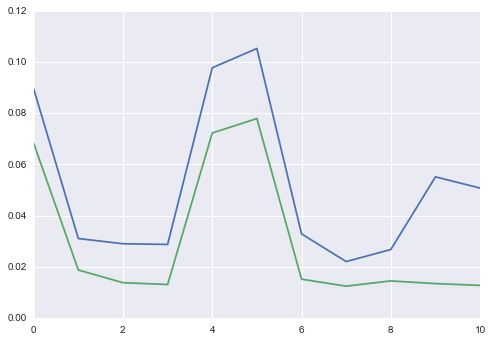

In [17]:
covs = []
lw_covs = []
for pair in pairs:
    t,tp1 = pair
    cov = np.mean((tp1.cov()-t.cov()).abs().sum())
    lw_cov = np.mean(np.sum(np.abs(covariance.ledoit_wolf(tp1)[0]-covariance.ledoit_wolf(t)[0]), axis=1))
    covs.append(cov)
    lw_covs.append(lw_cov)
    print("Standard: {}, Ledoit-Wolf: {}".format(cov,lw_cov))

plt.plot(covs)
plt.plot(lw_covs)

We can see the period to period error in the sample covariance is lower in all trials.